#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

In [ ]:
### Reading the Data File

In [2]:
data = pd.read_csv(r"C:\Users\raghu chand\Desktop\Kaggle\Ecom\data.csv", encoding= 'unicode_escape')

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
data.shape####541909, 8

(541909, 8)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


#### Missing Values:

In [7]:
## 1 -step make the list of features which has missing values--- Using List comprehension:
features_with_na = [features for features in data.columns if data[features].isnull().sum()>1]

In [8]:
features_with_na #### Two columns has missing values:

['Description', 'CustomerID']

In [9]:
## 2- step print the feature name and the percentage of missing values

for feature in features_with_na:
    print(feature, np.round(data[feature].isnull().mean(), 4),  ' % missing values')

Description 0.0027  % missing values
CustomerID 0.2493  % missing values


In [10]:
### ~ 25% entries are having missing values with Customer ID blank, since we want to do Clustering without customer details it is redundant

data.dropna(axis = 0, subset = ['CustomerID', 'Description'], inplace = True)

In [11]:
print(data.shape)

(406829, 8)


In [12]:
data.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [13]:
data['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

In [14]:
data['Amount'] = data['Quantity']* data['UnitPrice']

In [15]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [16]:
data = data[['CustomerID', 'InvoiceNo', 'InvoiceDate', 'StockCode', 'Description','UnitPrice', 'Quantity', 'Amount', 'Country']]

In [17]:
data.head()

,CustomerID,InvoiceNo,InvoiceDate,StockCode,Description,UnitPrice,Quantity,Amount,Country
0,17850.0,536365,12/1/2010 8:26,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2.55,6,15.30,United Kingdom
1,17850.0,536365,12/1/2010 8:26,71053,WHITE METAL LANTERN,3.39,6,20.34,United Kingdom
2,17850.0,536365,12/1/2010 8:26,84406B,CREAM CUPID HEARTS COAT HANGER,2.75,8,22.00,United Kingdom
3,17850.0,536365,12/1/2010 8:26,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,3.39,6,20.34,United Kingdom
4,17850.0,536365,12/1/2010 8:26,84029E,RED WOOLLY HOTTIE WHITE HEART.,3.39,6,20.34,United Kingdom


#### EDA: Exploratory Data Analysis:

In [ ]:
## Grouping country wise Users, Transaction Counts, Transaction/Cust, Spends, Average Spends  &  Average Ticket Size

In [28]:
Country_wise_price = data.groupby('Country')['Quantity'].sum().sort_values(ascending = False)
Country_wise_price

Country
United Kingdom          4008533
Netherlands              200128
EIRE                     136329
Germany                  117448
France                   109848
Australia                 83653
Sweden                    35637
Switzerland               29778
Spain                     26824
Japan                     25218
Belgium                   23152
Norway                    19247
Portugal                  16044
Finland                   10666
Channel Islands            9479
Denmark                    8188
Italy                      7999
Cyprus                     6317
Singapore                  5234
Austria                    4827
Israel                     3990
Poland                     3653
Canada                     2763
Iceland                    2458
Unspecified                1789
Greece                     1556
USA                        1034
United Arab Emirates        982
Malta                       944
Lithuania                   652
Czech Republic              592


In [ ]:
summary_table = data.pivot_table(values = 'InvoiceNo', 

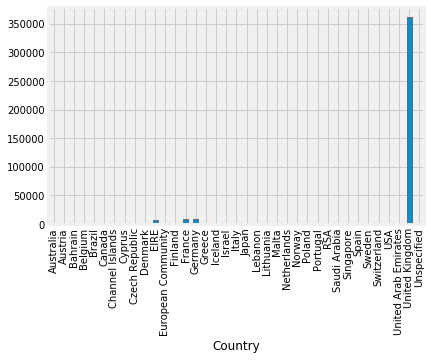

In [24]:
Country_wise_txns = data.groupby('Country')['InvoiceNo'].count().plot(kind = 'bar')

In [19]:
country_wise_txns

Country
Australia                 1259
Austria                    401
Bahrain                     17
Belgium                   2069
Brazil                      32
Canada                     151
Channel Islands            758
Cyprus                     622
Czech Republic              30
Denmark                    389
EIRE                      7485
European Community          61
Finland                    695
France                    8491
Germany                   9495
Greece                     146
Iceland                    182
Israel                     250
Italy                      803
Japan                      358
Lebanon                     45
Lithuania                   35
Malta                      127
Netherlands               2371
Norway                    1086
Poland                     341
Portugal                  1480
RSA                         58
Saudi Arabia                10
Singapore                  229
Spain                     2533
Sweden                     462


In [42]:
temp = data[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('Nb. de pays dans le dataframe: {}'.format(len(countries)))

Nb. de pays dans le dataframe: 37


In [ ]:
country_wise_txns = data.groupby('Country')['InvoiceNo'].count()